<a href="https://colab.research.google.com/github/luca-arts/luca-arts.github.io/blob/main/knowledge/AI/notebooks/Animal_faces_latent_interpolation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal faces interpolation

an example notebook to try to interpolate between two insects in latent space.

Based on [Noufals blog](https://medium.com/@noufalsamsudin/latent-space-interpolation-of-images-using-keras-and-tensorflow-js-7e35bec01c5a) & [classification code on Kaggle](https://www.kaggle.com/code/vencerlanz09/insect-classification-using-cnn-mobilenetv2)


In [1]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Tensorflow Libraries
from tensorflow import keras
from tensorflow.keras import layers,models
from keras_preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping,ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import Model
from tensorflow.keras.layers.experimental import preprocessing

In [3]:
# System libraries
from pathlib import Path
import os.path


In [4]:
# Metrics
from sklearn.metrics import classification_report, confusion_matrix
import itertools

## downloading the Kaggle dataset

Make sure you upload your Kaggle API key JSON file here. (via Kaggle, profile, Account)

Via [link](https://www.analyticsvidhya.com/blog/2021/06/how-to-load-kaggle-datasets-directly-into-google-colab/)

In [5]:
dataset_name = "andrewmvd/animal-faces"
dataset = "animal-faces"

In [6]:
!pip install kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download {dataset_name}
!unzip {dataset}.zip

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists
animal-faces.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  animal-faces.zip
replace afhq/train/cat/flickr_cat_000002.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace afhq/train/cat/flickr_cat_000003.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


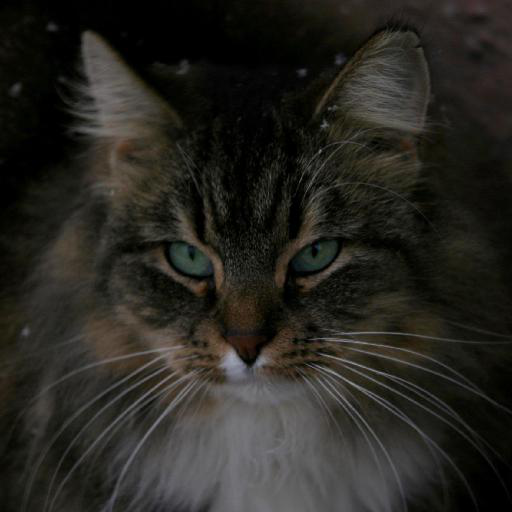

In [7]:
test_img = keras.utils.load_img('/content/afhq/train/cat/flickr_cat_000002.jpg')
test_img

In [50]:
# hyperparameters
BATCH_SIZE = 64
img_height = 512
img_width = 512
# Load the data
ds = keras.utils.image_dataset_from_directory(
    '/content/afhq/train',
    labels="inferred", 
    label_mode="int",
    batch_size=BATCH_SIZE, 
    image_size=(img_height,img_width) 
    )
print(type(ds))

Found 14630 files belonging to 3 classes.
<class 'tensorflow.python.data.ops.dataset_ops.BatchDataset'>


wild


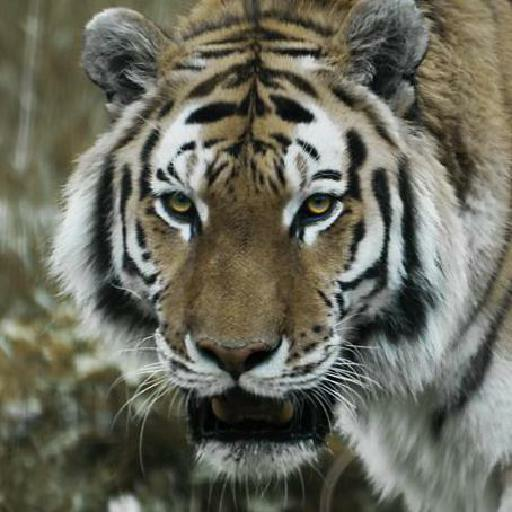

In [51]:
# show the first example of the batch
it = iter(ds)
test_img_batch = next(it)
test_img = test_img_batch[0][0]
test_img_label = test_img_batch[1][0]
print(ds.class_names[test_img_label.numpy()])
test_img = keras.preprocessing.image.array_to_img(test_img)
test_img

In [10]:
for image_batch, labels_batch in ds:
  print(image_batch.shape)
  print(image_batch.shape[1:])

  print(labels_batch.shape)
  break

(64, 512, 512, 3)
(512, 512, 3)
(64,)


In [23]:
# preprocessing of data
AUTOTUNE = tf.data.AUTOTUNE
prepr_ds = ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)

# # normalize the data
normalization_layer = layers.Rescaling(1./255)
normalized_ds = prepr_ds.map(lambda x,y: (normalization_layer(x),y))
# image_batch, labels_batch = next(iter(normalized_ds))
# first_image = image_batch[0]
# # Notice the pixel values are now in `[0,1]`.
# print(np.min(first_image), np.max(first_image))

In [45]:
from keras.layers import Input, Rescaling, Conv2D, MaxPooling2D, Flatten, Reshape, UpSampling2D
# auto-encoder model
input=Input(shape=image_batch.shape[1:])
encoded=Conv2D(16, (3, 3), activation='relu', padding='same')(input)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
encoded=MaxPooling2D((2, 2), padding='same')(encoded)
encoded=Conv2D(8, (3, 3), strides=(2,2), activation='relu', padding='same')(encoded)
encoded=Flatten()(encoded)

decoded=Reshape((64,64,-1))(encoded)#(32, 32, 32))(encoded)
decoded=Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(8, (3, 3), activation='relu', padding='same')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(16, (3, 3), activation='relu')(decoded)
decoded=UpSampling2D((2, 2))(decoded)
decoded=Conv2D(3, (3, 3), activation='sigmoid', padding='same')(decoded)
        
autoencoder=Model(input,decoded)
#TODO: decoder has wrong shape at the end?
autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_120 (Conv2D)         (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 256, 256, 8)       1160      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 64, 64, 8)         584

In [46]:
encoder = Model(inputs=autoencoder.input, outputs = autoencoder.layers[6].output)
encoder.summary()

Model: "model_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_25 (InputLayer)       [(None, 512, 512, 3)]     0         
                                                                 
 conv2d_120 (Conv2D)         (None, 512, 512, 16)      448       
                                                                 
 max_pooling2d_38 (MaxPoolin  (None, 256, 256, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_121 (Conv2D)         (None, 256, 256, 8)       1160      
                                                                 
 max_pooling2d_39 (MaxPoolin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_122 (Conv2D)         (None, 64, 64, 8)         584

In [47]:
encoded_input = Input(shape=(32768,))

deco = autoencoder.layers[-8](encoded_input)
deco = autoencoder.layers[-7](deco)
deco = autoencoder.layers[-6](deco)
deco = autoencoder.layers[-5](deco)
deco = autoencoder.layers[-4](deco)
deco = autoencoder.layers[-3](deco)
deco = autoencoder.layers[-2](deco)
deco = autoencoder.layers[-1](deco)
# create the decoder model
decoder = Model(encoded_input, deco)
decoder.summary()

Model: "model_22"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32768)]           0         
                                                                 
 reshape_19 (Reshape)        (None, 64, 64, 8)         0         
                                                                 
 conv2d_123 (Conv2D)         (None, 64, 64, 8)         584       
                                                                 
 up_sampling2d_45 (UpSamplin  (None, 128, 128, 8)      0         
 g2D)                                                            
                                                                 
 conv2d_124 (Conv2D)         (None, 128, 128, 8)       584       
                                                                 
 up_sampling2d_46 (UpSamplin  (None, 256, 256, 8)      0         
 g2D)                                                     

In [48]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [49]:
len(autoencoder.layers),len(encoder.layers),len(decoder.layers)

(15, 7, 9)

In [56]:
autoencoder.fit(normalized_ds, epochs=4, steps_per_epoch=10)

Epoch 1/4


ValueError: ignored